In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from skimage import data, filters
from scipy.interpolate import interpn
import os

In [5]:
igram_date = '20191109_20191121'
work_dir = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12'
veloc_fn = f'{work_dir}/mintpy_offsets/velocity.h5'
igram_fn = f'{work_dir}/work/merged/interferograms/{igram_date}/filt_fine.int'
cor_fn = f'{work_dir}/work/merged/interferograms/{igram_date}/filt_fine.cor'

In [3]:
igram_ds = gdal.Open(igram_fn, gdal.GA_ReadOnly)
igram = igram_ds.GetRasterBand(1).ReadAsArray()

cor_ds = gdal.Open(cor_fn, gdal.GA_ReadOnly)
cor = cor_ds.GetRasterBand(1).ReadAsArray()

In [11]:
ds = xr.open_dataset(veloc_fn)
veloc = ds.velocity.values

In [12]:
# filter to remove some noise
veloc_filtered = filters.butterworth(veloc,
                                     cutoff_frequency_ratio=0.35, #between 0 and 0.5
                                     order=2,
                                     high_pass=False)

In [13]:
# convert to phase for simulated 12 day period
veloc_unwrapped = (veloc_filtered-0.6)*(12/365)*(12.5663706/0.05546576)

In [20]:
igram_aoi = igram[3250:4750, 2600:4100]
cor_aoi = cor[3250:4750, 2600:4100]

In [23]:
# wrap, convert to complex conjugate, and remove from interferogram
veloc_wrapped = np.mod(veloc_unwrapped,2*np.pi)
complex_conjugate_array = np.conjugate(np.exp(1j * veloc_wrapped))
residual = igram_aoi*complex_conjugate_array

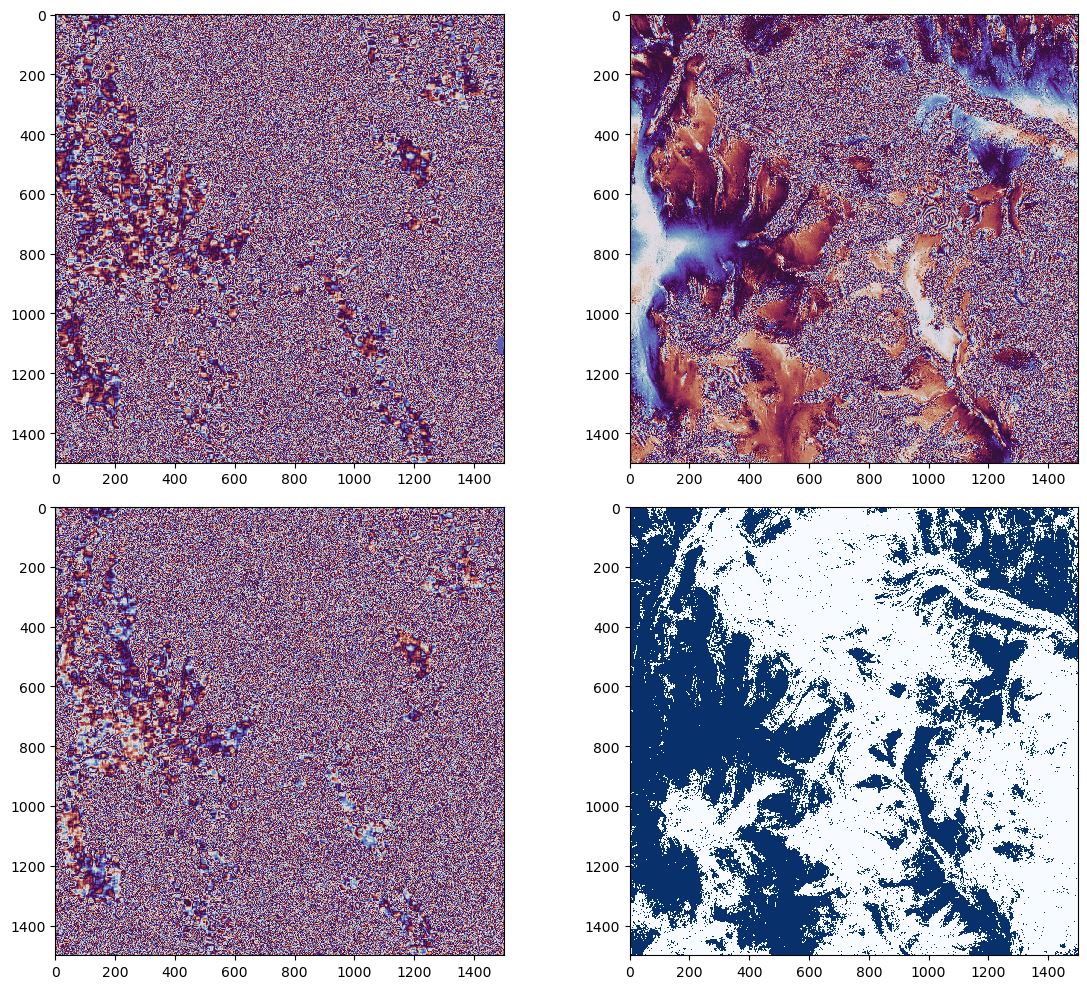

In [26]:
f, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].imshow(np.flip(veloc_wrapped, 0), cmap='twilight', interpolation='none')
ax[0, 1].imshow(np.flip(np.angle(igram_aoi), 0), cmap='twilight', interpolation='none')
ax[1, 0].imshow(np.flip(np.angle(residual), 0), cmap='twilight_shifted', interpolation='none')
ax[1, 1].imshow(np.flip(cor_aoi, 0), cmap='Blues', vmin=0.5, vmax=0.501, interpolation='none')
f.tight_layout()

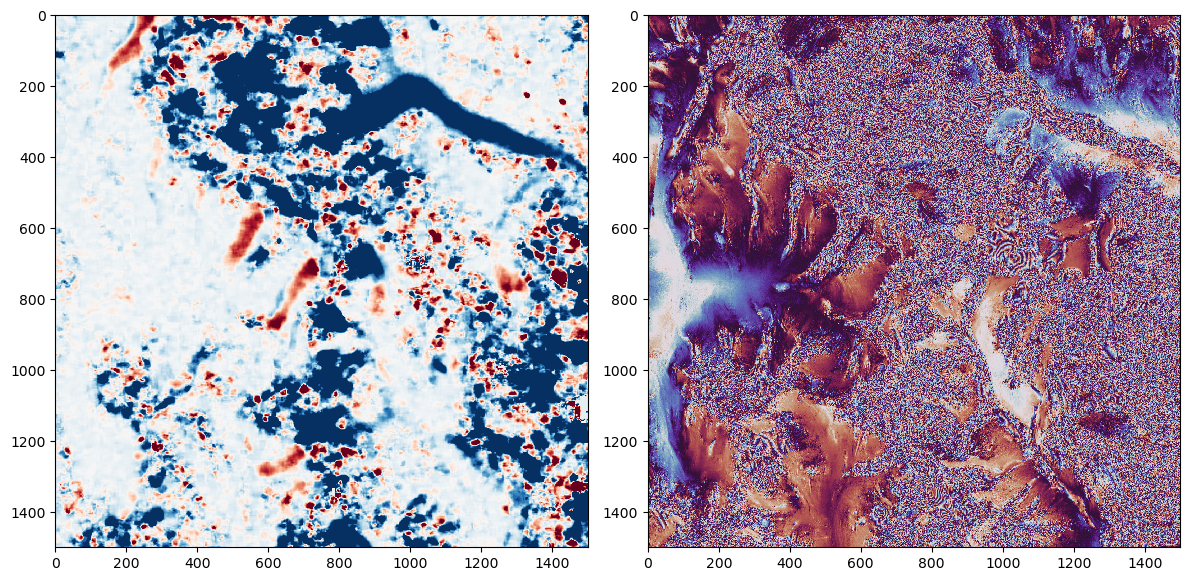

In [30]:
f, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(np.flip(veloc_unwrapped, 0), cmap='RdBu_r', vmin=-50, vmax=50, interpolation='none')
ax[1].imshow(np.flip(np.angle(igram_aoi), 0), cmap='twilight', interpolation='none')
f.tight_layout()

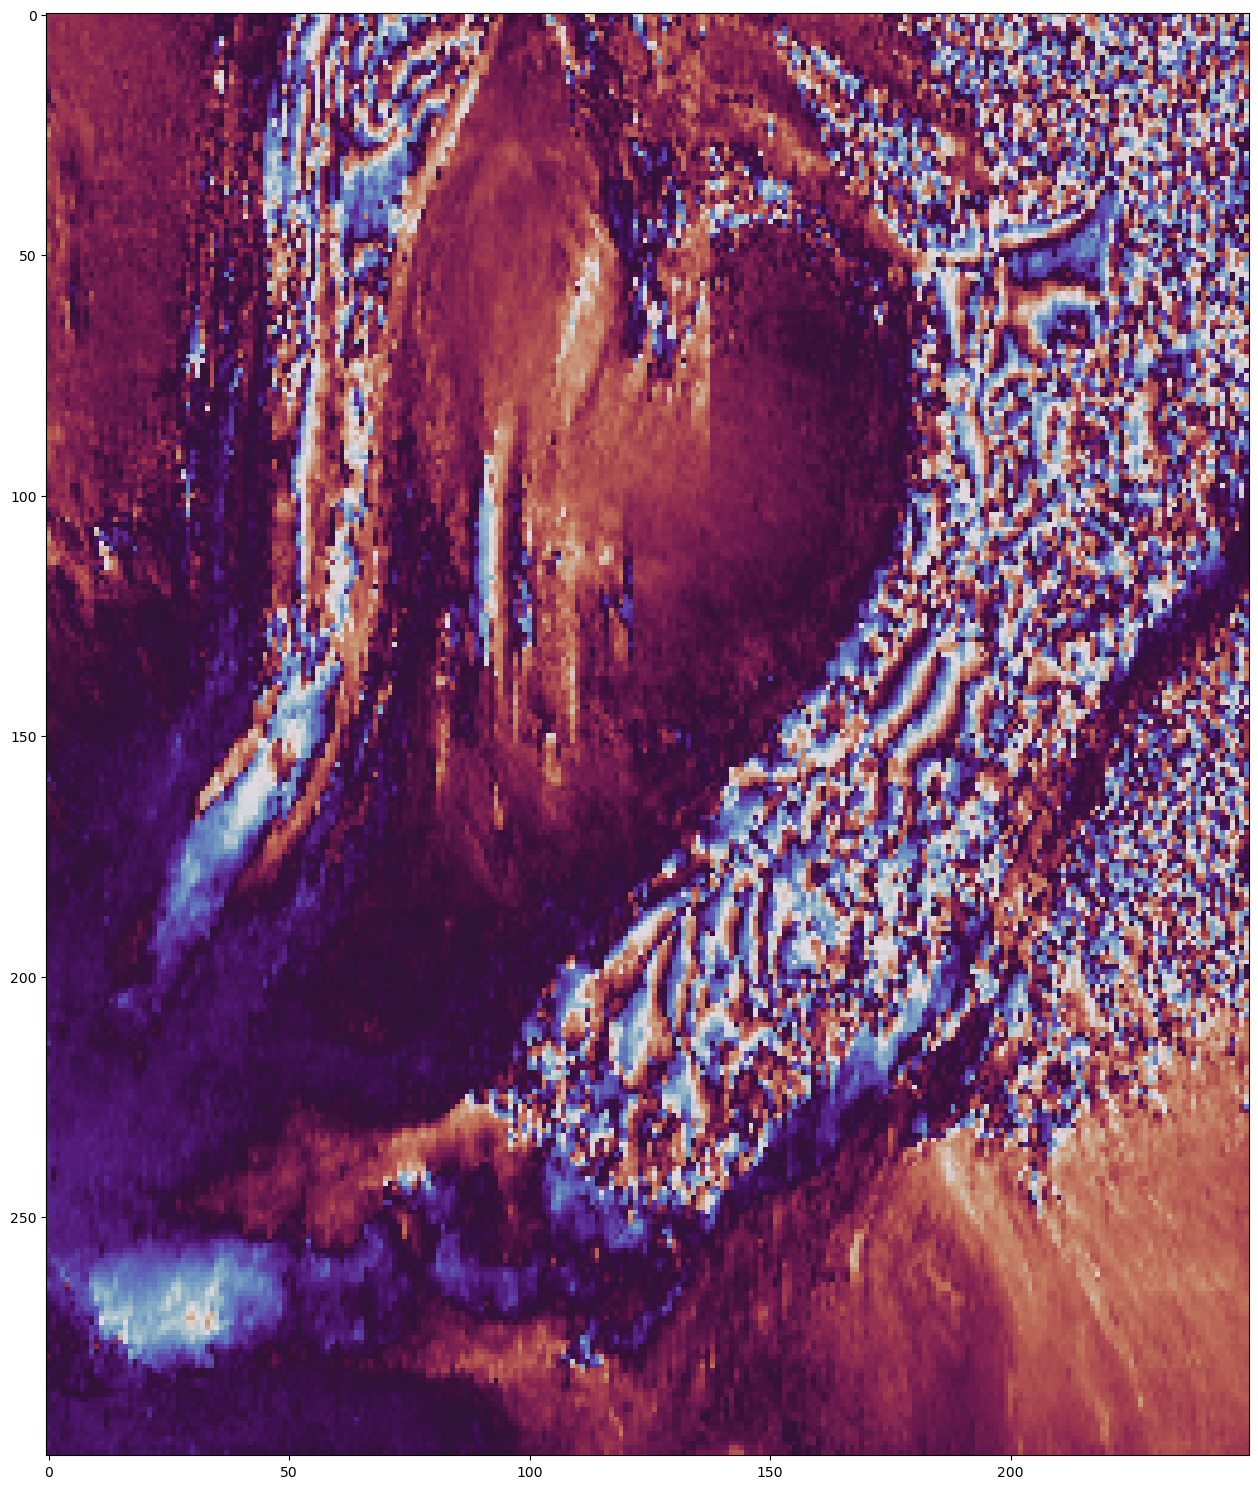

In [61]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(np.flip(np.angle(igram_aoi), 0)[500:800, 350:600], cmap='twilight', interpolation='none')
f.tight_layout()
f.savefig('figs/20191109_20191121_igram_wrapped.png', dpi=300)

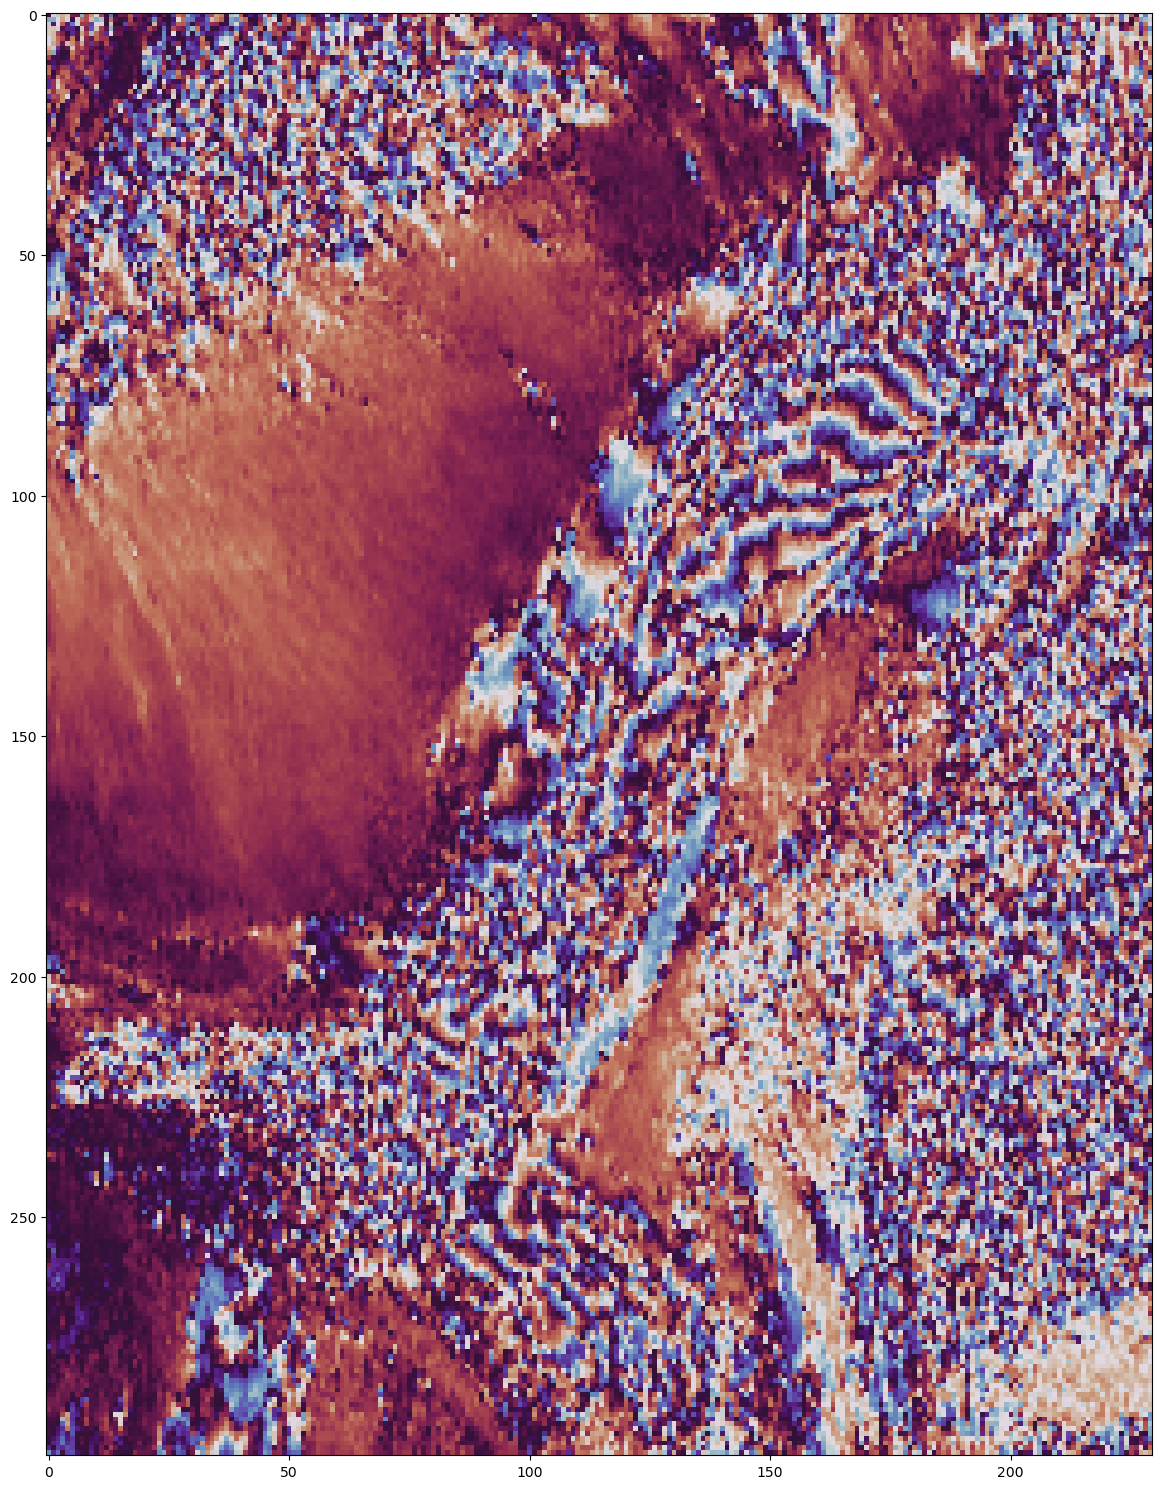

In [49]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(np.flip(np.angle(igram_aoi), 0)[650:950, 550:780], cmap='twilight', interpolation='none')
f.tight_layout()
f.savefig('figs/20191109_20191121_igram_wrapped.png', dpi=300)

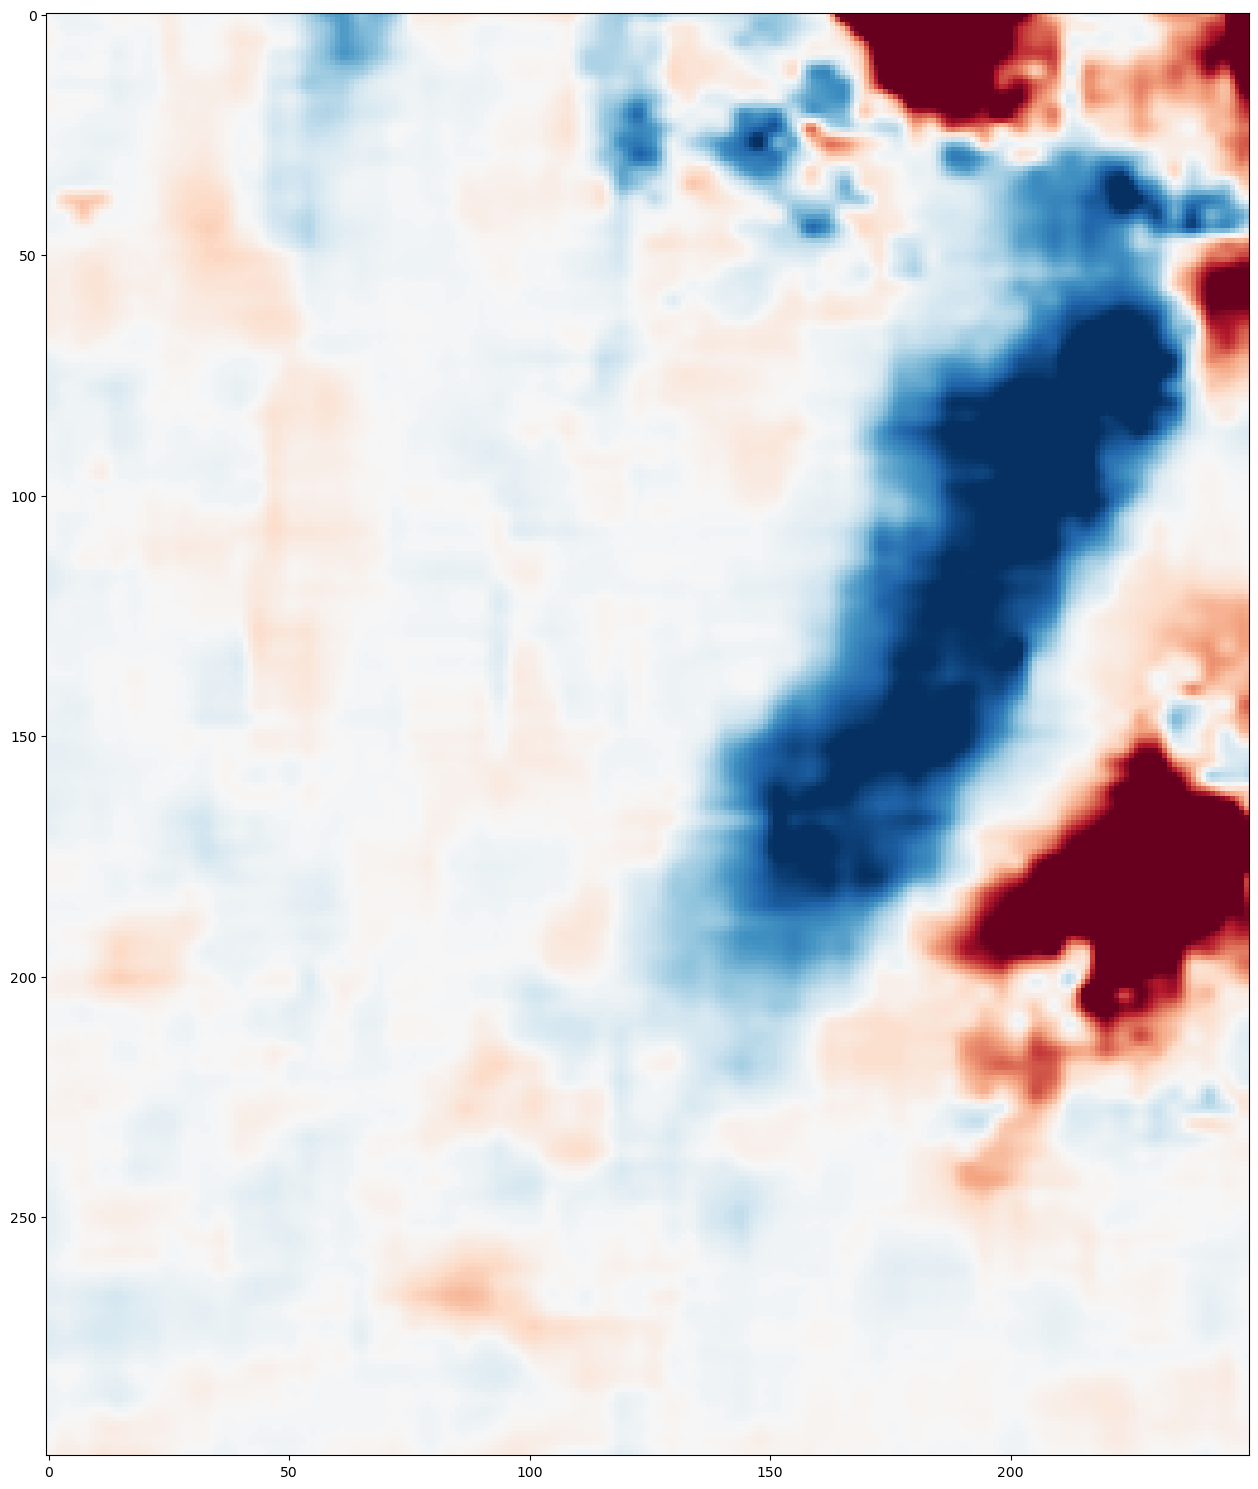

In [67]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(np.flip(veloc_unwrapped, 0)[500:800, 350:600], cmap='RdBu', vmin=-43, vmax=37, interpolation='none')
f.tight_layout()
f.savefig('figs/20191109_20191121_speckle_unwrapped.png', dpi=300)

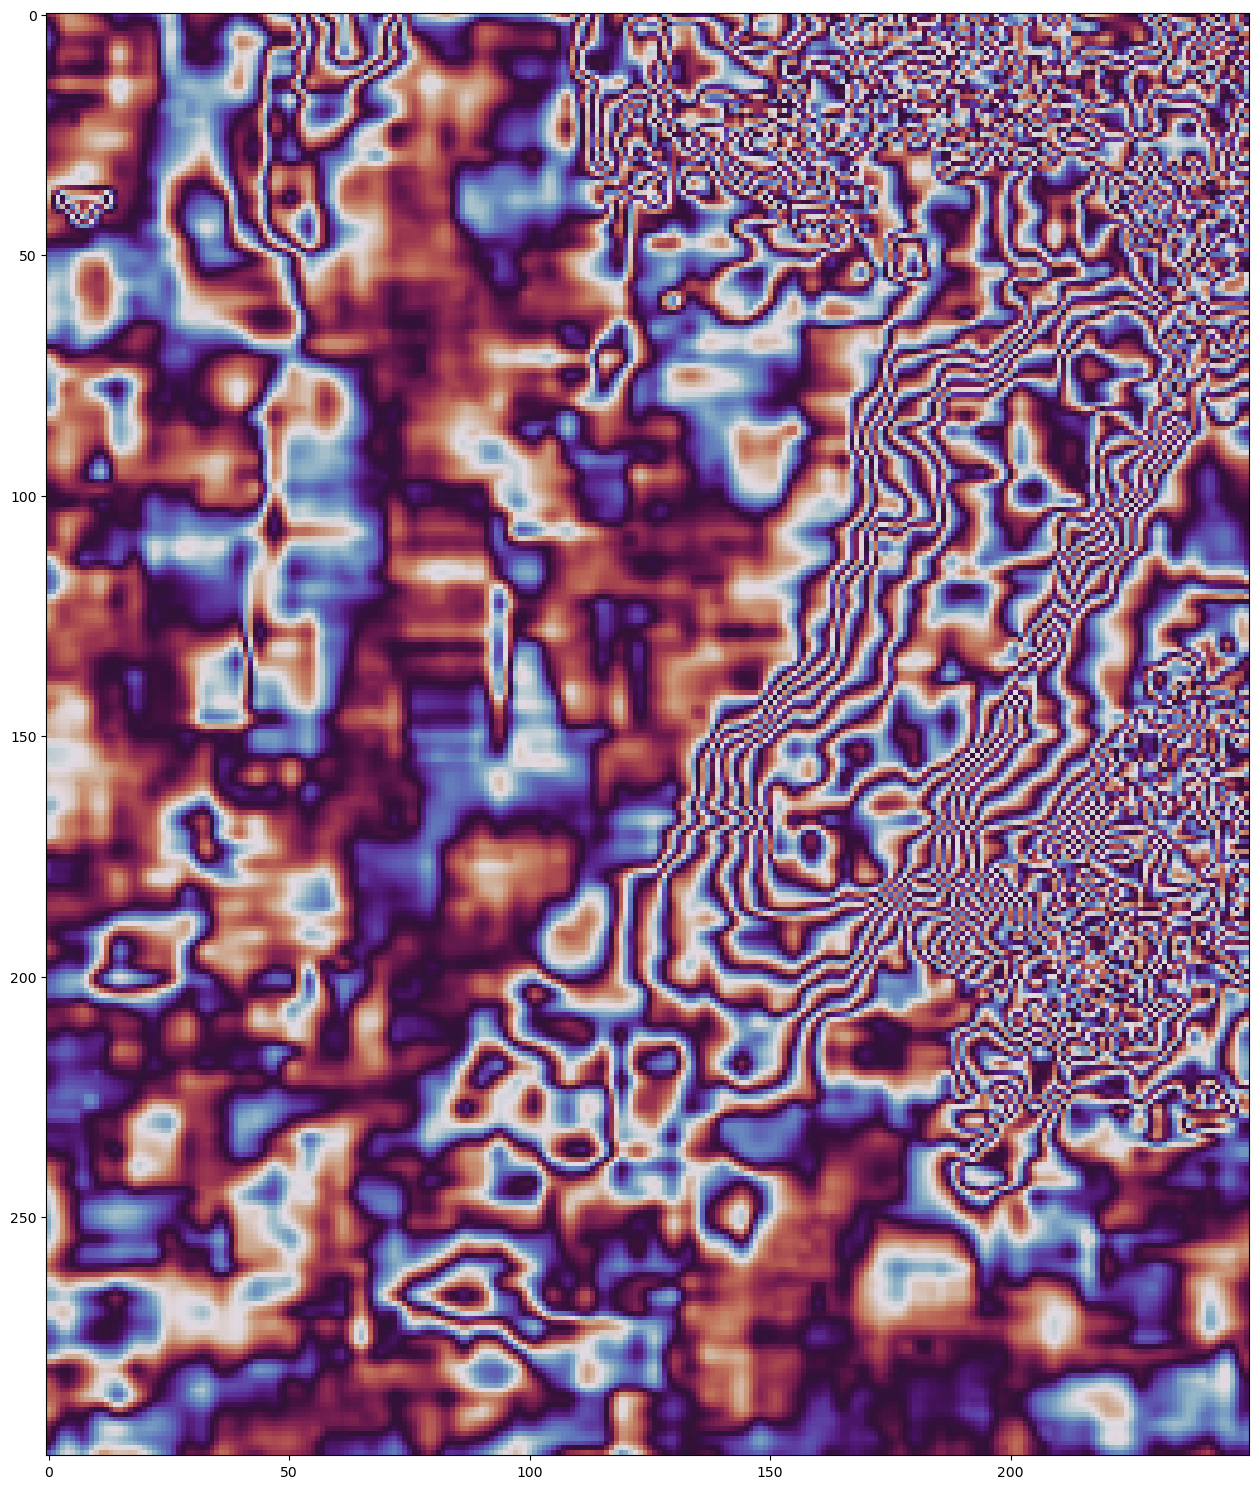

In [57]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(np.flip(veloc_wrapped, 0)[500:800, 350:600], cmap='twilight', interpolation='none')
f.tight_layout()
f.savefig('figs/20191109_20191121_speckle_wrapped.png', dpi=300)

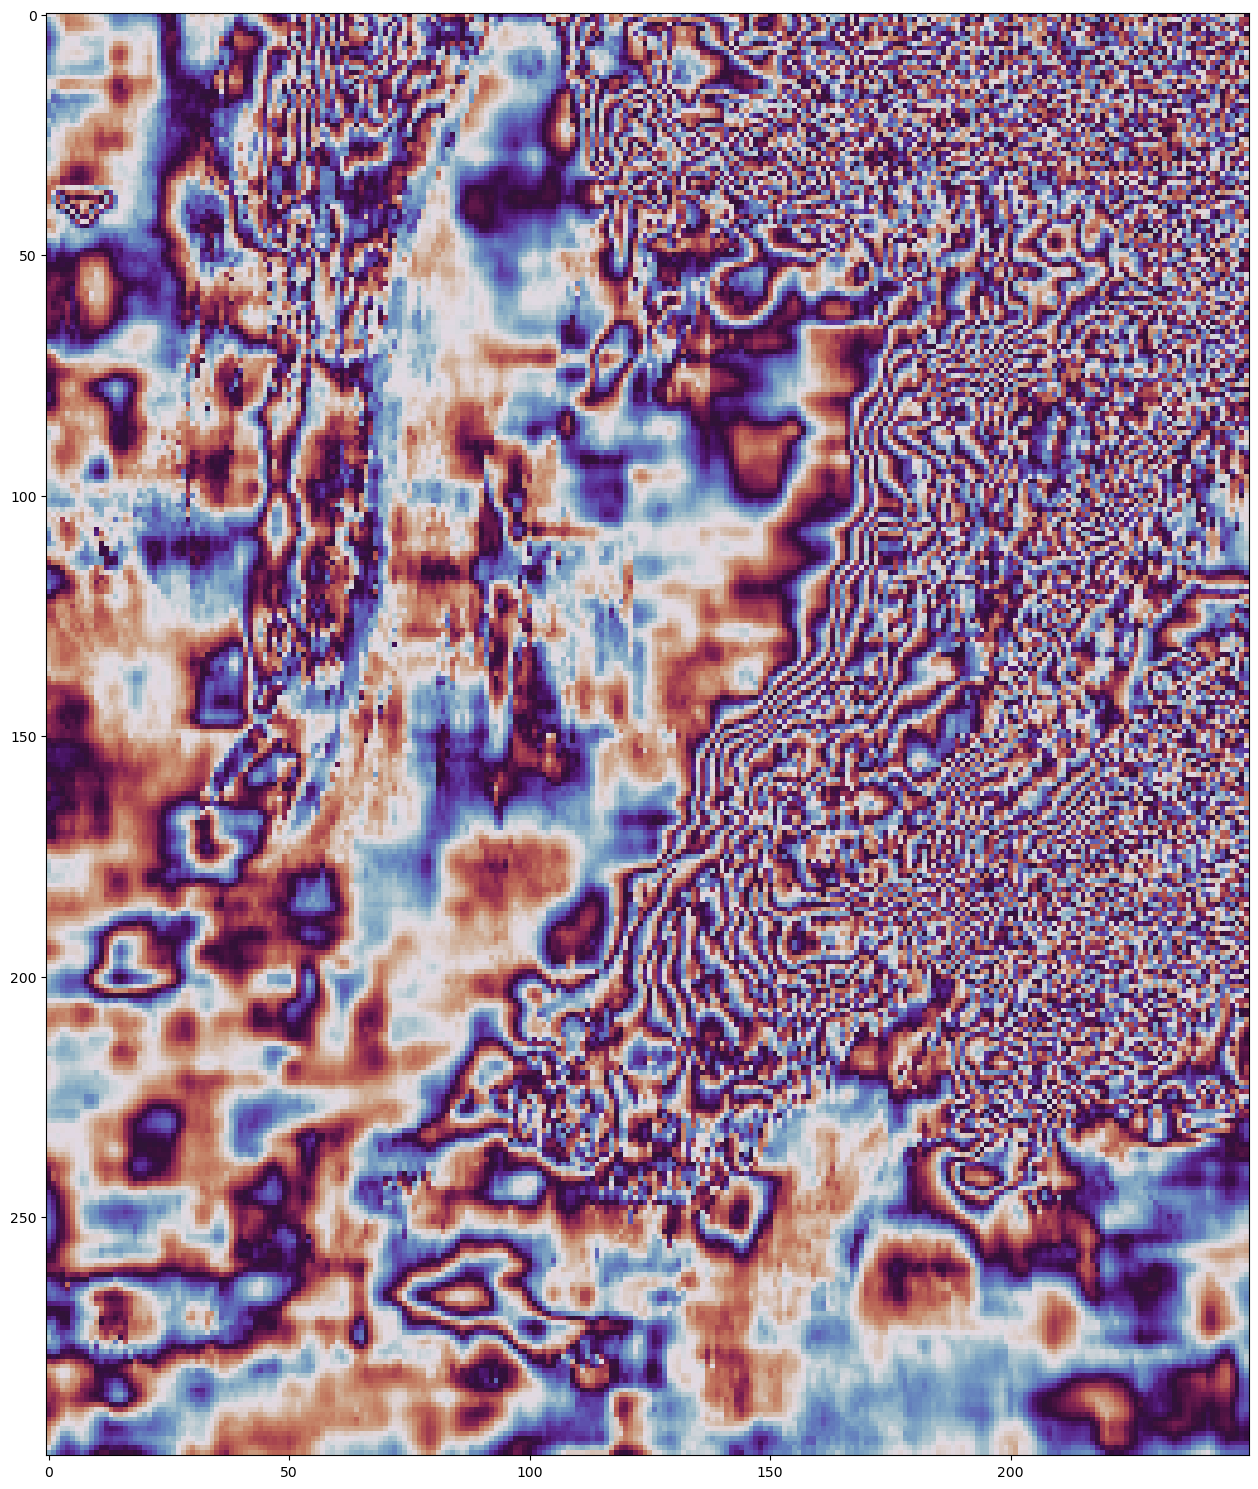

In [62]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(np.flip(np.angle(residual), 0)[500:800, 350:600], cmap='twilight', interpolation='none')
f.tight_layout()
f.savefig('figs/20191109_20191121_residual.png', dpi=300)

In [68]:
veloc_unwrapped = np.nan_to_num(veloc_unwrapped, nan=0)
veloc_unwrapped = veloc_unwrapped.astype(np.float32)

# save to raster
output_file = f'{work_dir}/work/merged/interferograms/{igram_date}/veloc_unwrapped_aoi' 
driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
rows, cols = veloc_unwrapped.shape    # Get the number of rows and columns from the NumPy array
data_type = gdal_array.NumericTypeCodeToGDALTypeCode(veloc_unwrapped.dtype)  # Convert NumPy data type to GDAL data type

# Create the output dataset
driver = gdal.GetDriverByName(driver_format)
output_ds = driver.Create(output_file, cols, rows, 1, data_type)

band = output_ds.GetRasterBand(1)  # Get the single band
band.WriteArray(veloc_unwrapped)
output_ds = None

In [ ]:
igram_aoi = np.nan_to_num(igram_aoi, nan=0)
igram_aoi = igram_aoi.astype(np.complex64)

# # For complex input
# real_array = np.real(igram_aoi).astype(np.float32)
# imaginary_array = np.imag(igram_aoi).astype(np.float32)

# # Stack the real and imaginary parts alternately
# igram_aoi = np.hstack((real_array, imaginary_array))

# save to raster
output_file = f'{work_dir}/work/merged/interferograms/{igram_date}/filt_fine_aoi.int' 
driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
rows, cols = igram_aoi.shape    # Get the number of rows and columns from the NumPy array
data_type = gdal_array.NumericTypeCodeToGDALTypeCode(igram_aoi.dtype)  # Convert NumPy data type to GDAL data type

# Create the output dataset
driver = gdal.GetDriverByName(driver_format)
output_ds = driver.Create(output_file, cols, rows, 1, data_type)

band = output_ds.GetRasterBand(1)  # Get the single band
band.WriteArray(igram_aoi)
output_ds = None

In [ ]:
cor_aoi = np.nan_to_num(cor_aoi, nan=0)
cor_aoi = cor_aoi.astype(np.float32)

# save to raster
output_file = f'{work_dir}/work/merged/interferograms/{igram_date}/filt_fine_aoi.cor' 
driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
rows, cols = cor_aoi.shape    # Get the number of rows and columns from the NumPy array
data_type = gdal_array.NumericTypeCodeToGDALTypeCode(cor_aoi.dtype)  # Convert NumPy data type to GDAL data type

# Create the output dataset
driver = gdal.GetDriverByName(driver_format)
output_ds = driver.Create(output_file, cols, rows, 1, data_type)

band = output_ds.GetRasterBand(1)  # Get the single band
band.WriteArray(cor_aoi)
output_ds = None

In [ ]:
# byte_mask = (cor_aoi > 0.35).astype(np.uint8)

# # save to raster
# output_file = f'{work_dir}/work/merged/interferograms/{igram_date}/cor_mask_0.35' 
# driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
# rows, cols = byte_mask.shape    # Get the number of rows and columns from the NumPy array
# data_type = gdal_array.NumericTypeCodeToGDALTypeCode(byte_mask.dtype)  # Convert NumPy data type to GDAL data type

# # Create the output dataset
# driver = gdal.GetDriverByName(driver_format)
# output_ds = driver.Create(output_file, cols, rows, 1, data_type)

# band = output_ds.GetRasterBand(1)  # Get the single band
# band.WriteArray(byte_mask)
# output_ds = None

In [69]:
os.chdir(f'{work_dir}/work/merged/interferograms/{igram_date}')

In [70]:
# Function to write to MintPy config file
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for snaphu to process products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

In [71]:
CONFIG_TXT = f'''# snaphu configuration file
#############################################
# File input and output and runtime options #
#############################################

# Input file name
INFILE	filt_fine_aoi.int

# Input file line length 
LINELENGTH	1500

# Output file name
OUTFILE	fine_filt_aoi_smooth_withest.unw

# Correlation file name
CORRFILE	filt_fine_aoi.cor

# Coarse unwrapped-phase estimate file name (see possible file formats
# below).  The array should have the same dimensions as the input
# wrapped phase array.
ESTIMATEFILE	veloc_unwrapped_aoi

# Input file of signed binary byte (signed char) values.  
# BYTEMASKFILE  cor_mask_0.35

# Text file to which runtime parameters will be logged.  
LOGFILE       snaphu.logfile

# Statistical-cost mode (TOPO, DEFO, SMOOTH, or NOSTATCOSTS)
STATCOSTMODE	SMOOTH

# Algorithm used for initialization of wrapped phase values.  Possible
# values are MST and MCF.  
INITMETHOD	MCF

################
# File formats #
################

# Input file format
INFILEFORMAT		COMPLEX_DATA

# Output file format
OUTFILEFORMAT		FLOAT_DATA

# Correlation file format
CORRFILEFORMAT		FLOAT_DATA

# Unwrapped estimate file format
ESTFILEFORMAT		FLOAT_DATA



# End of snaphu configuration file'''

config_file = 'snaphu.conf.brief'
write_config_file(config_file, CONFIG_TXT, mode='w')

write configuration to file: snaphu.conf.brief


In [72]:
!snaphu -f snaphu.conf.brief


snaphu v2.0.6
12 parameters input from file snaphu.conf.brief (54 lines total)
Logging run-time parameters to file snaphu.logfile
Reading wrapped phase from file filt_fine_aoi.int
Reading coarse unwrapped estimate from file veloc_unwrapped_aoi
No weight file specified.  Assuming uniform weights
Reading correlation data from file filt_fine_aoi.cor
Calculating smooth-solution cost parameters
Initializing flows with MCF algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 11
Flow increment: 1  (Total improvements: 0)
623 incremental costs clipped to avoid overflow (0.000%)
Found 1 valid set(s) of connected nodes
Flow increment: 2  (Total improvements: 724485)
6 incremental costs clipped to avoid overflow (0.000%)
Found 1 valid set(s) of connected nodes
Flow increment: 3  (Total improvements: 724503)
Found 1 valid set(s) of connected nodes
Flow increment: 4  (Total improvements: 724503)
Found 1 valid set(s) of connected nodes
Maximum flow on network: 22
Total soluti

In [73]:
smooth_withest_file = gdal.Open('fine_filt_aoi_smooth_withest.unw', gdal.GA_ReadOnly)
smooth_withest = smooth_withest_file.GetRasterBand(1).ReadAsArray()
# conn_comp_file = gdal.Open('conn_comp_aoi', gdal.GA_ReadOnly)
# conn_comp = conn_comp_file.GetRasterBand(1).ReadAsArray()

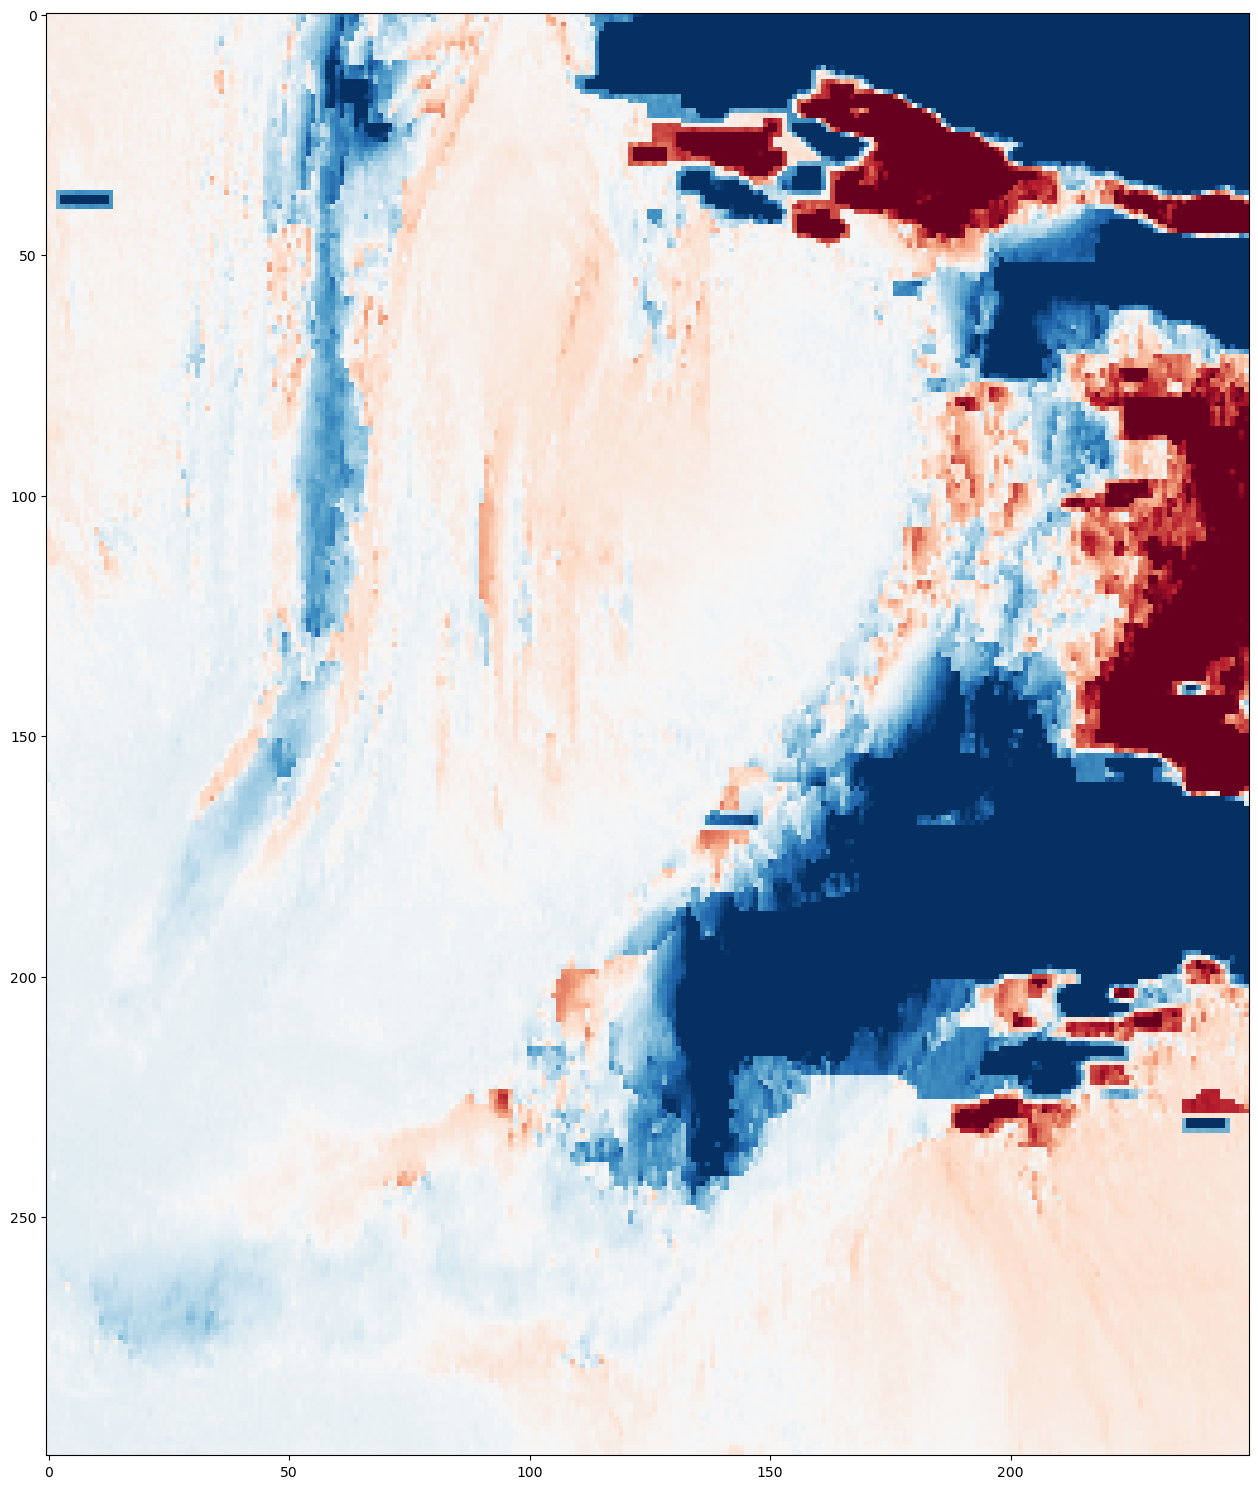

In [91]:
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(np.flip(smooth_withest, 0)[500:800, 350:600], cmap='RdBu_r', vmin=3, vmax=23, interpolation='none')
f.tight_layout()
f.savefig('../../../../../figs/20191109_20191121_unwrapped.png', dpi=300)

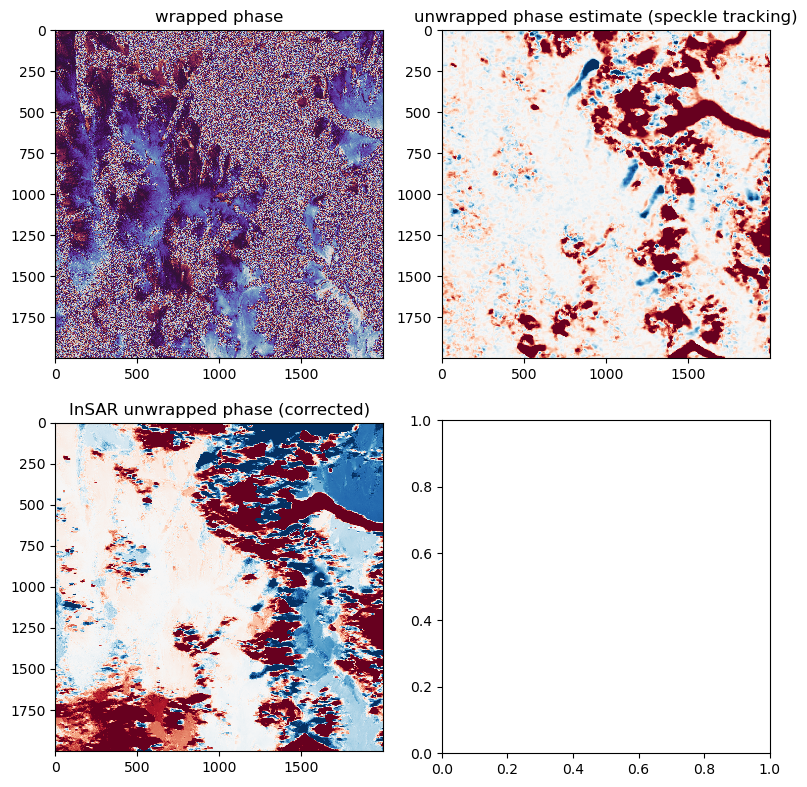

In [60]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(np.flip(np.angle(igram_aoi), 0), cmap='twilight', interpolation='none')
ax[0, 0].set_title('wrapped phase')
ax[0, 1].imshow(np.flip(veloc_unwrapped_aoi, 0), cmap='RdBu_r', vmin=-50, vmax=50, interpolation='none')
ax[0, 1].set_title('unwrapped phase estimate (speckle tracking)')
ax[1, 0].imshow(np.flip(smooth_withest, 0)+20, cmap='RdBu_r', vmin=-25, vmax=25, interpolation='none')
ax[1, 0].set_title('InSAR unwrapped phase (corrected)')
# ax[1, 1].imshow(np.flip(smooth_noest, 0)-5, cmap='RdBu_r', vmin=-25, vmax=25, interpolation='none')
# ax[1, 1].set_title('InSAR unwrapped phase (no unwrapping correction)')
f.tight_layout()

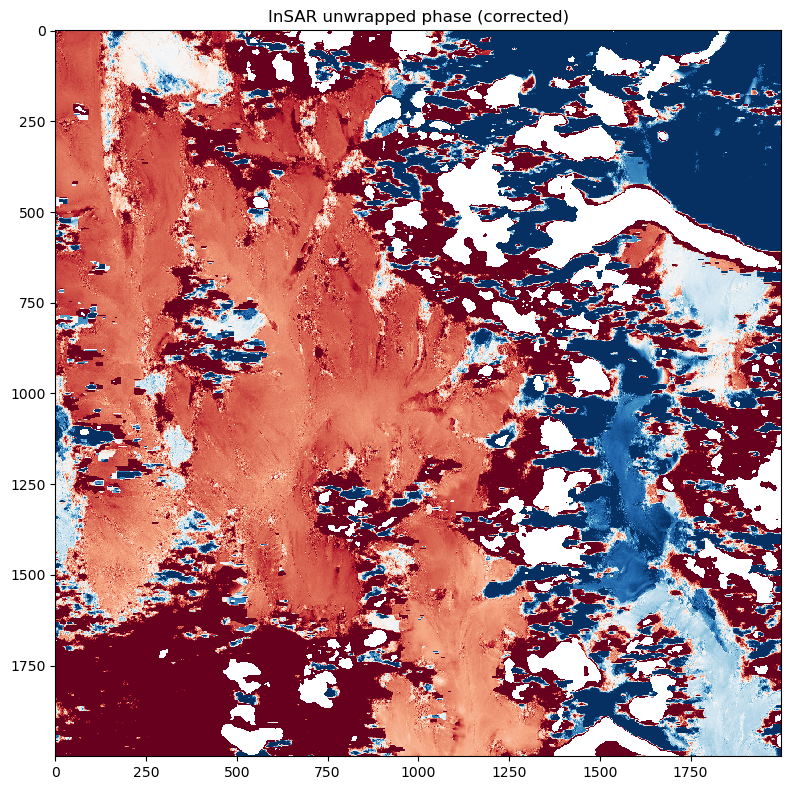

In [75]:
f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.flip(np.where(np.abs(veloc_unwrapped_aoi)<50, smooth_withest, np.nan), 0)+25, cmap='RdBu_r', vmin=-10, vmax=10, interpolation='none')
ax.set_title('InSAR unwrapped phase (corrected)')
f.tight_layout()

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.flip(smooth_noest, 0)-6, cmap='RdBu_r', vmin=-30, vmax=30, interpolation='none')
ax.set_title('InSAR unwrapped phase (corrected)')
f.tight_layout()